# **Global Sentiment**

En este cuaderno mostraremos la forma de extraer el *Sentimiento Global*, métrica que hemos desarrollado para este proyecto.

## ¿Que es el Sentimiento Global?

Normalmente, cuando miramos el "sentimiento" de un Tweet, lo hacemos fijandonos en la polaridad del mismo. Una vez se consiguen todas las polaridades, la mayoria de herramientas que hemos visto, usan la media del "sentimiento" como medida de Sentimiento Global en Twitter.

* https://alternative.me/crypto/fear-and-greed-index/
* https://www.crypto-sentiment.com/
* https://www.bittsanalytics.com/sentiment-index/BTC

Nosotros rechazamos esta idea. 

Para encontrar una métrica más efectiva, planteamos la siguiente fórmula:

$$S(P) = \sum_{m \in P} m_s * (1 + \log_2(1 + m_l))$$

donde $S(P)$ es un mapeo de una lista de mensajes a un número real, $P$ es una lista de mensajes de un periodo conexo de tiempo, $m_s$ es la polaridad de un mensaje y $m_l$ es el *impacto* de un tweet, en este caso, los likes.

Se pueden considerar diferentes formas de impacto haciendo uso del número de contestaciones, retweets, likes, likes a las contestaciones, etc, pero en este estudio vamos a mantener la simplicidad.


## Imports y Parametros

In [1]:
import datetime
from datetime import timedelta

import os
import re

import snscrape.modules.twitter as snstwitter

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

Podemos escoger las fechas que queremos analizar. Para poder analizarlas, debemos tener los archivos de las fechas correspondientes descargados, sino no podremos ejecutar el analisis.

In [2]:
date_init = "2014-01-01"
date_limit = "2021-06-14"

## **Read Databases**

Definimos la carpeta donde se encuentran los datos así como los nombres de los archivos.

In [3]:
t_path = "JABA/data/tweets"
t_file = "tweet_list.csv"
s_file = "tweet_sentiment_nltk.csv"

La base de datos esta formada por millones de filas y no usaremos todas las columnas, por lo que, para acelerar el proceso, eliminaremos las columnas no usadas.

In [4]:
unused_columns = ['Text', 'Tweet Id', 'NumReplies', 'NumRetweets', 'IDOriginalRetweeted', 'isVerified'  ]

def drop_unused_columns(dataframe):
    return dataframe.drop(unused_columns,  axis=1)

Para preparar los datos haremos un conjunto de transformaciones que tienen los siguientes objetivos:

* Preparar la fila de Sentimiento Global
* Agrupar los datos por cada media hora
* Preparar la fila de Sentimiento Global V2

In [5]:
def prepare_data(dataframe):
    dataframe["Datetime"] = pd.to_datetime(dataframe["Datetime"])
    dataframe['sentiment_v'] = ( 1 + np.log2(1 + dataframe['NumLikes']) ) * dataframe['sentiment'] 
    dataframe["round_datetime"] = dataframe["Datetime"].dt.floor("30T")
    
    dataframe["date"] = dataframe["Datetime"].dt.date
    dataframe = dataframe.set_index('date')
    
    dataframe = dataframe.groupby(['round_datetime', 'Username']).agg({'sentiment_v' : 'sum' , 'Datetime':'count'})

    dataframe['sentiment_v2'] = np.log2(1+dataframe['Datetime']) / dataframe['Datetime'] * dataframe['sentiment_v']
    return dataframe.groupby('round_datetime').sum()

Definimos una función que recoja los archivos de las fechas correspondientes, los limpie y los una.

In [6]:
def get_data():
    frames = []
    date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
    date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()
    
    if date_from >= date_until:
        return pd.DataFrame()
    
    while date_from < date_until:
        
        folder = os.path.join(t_path, str(date_from))
        # TODO Check if file exists
        if date_from.day == 1 and date_from.month == 1:
            print(f"Current Date {str(date_from)}")

        tweet_file = os.path.join(folder, t_file)
        sentiment_file = os.path.join(folder, s_file)

        tweet_df = pd.read_csv(tweet_file, sep=";")
        tweet_df = drop_unused_columns(tweet_df)

        sent_df = pd.read_csv(sentiment_file, sep=";")

        tweet_df = prepare_data(tweet_df.join(sent_df))
        
        frames += [tweet_df]
        
        date_from = date_from + timedelta(days=1)
    
    return pd.concat(frames, ignore_index=False)

In [7]:
df = get_data()
print("Extraction Completed!")

Current Date 2014-01-01
Current Date 2015-01-01
Current Date 2016-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed!


## **Get Bitcoin Data**

In [8]:
b_path = "JABA/data/bitcoin"
b_file = "bitcoin.csv"

b_limit = date_limit

In [9]:
btc_df = pd.DataFrame()

frames = []
date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()

while date_from < date_until:

    folder = os.path.join(b_path, str(date_from))
    btc_file = os.path.join(folder, b_file)
    # TODO Check if file exists
    if date_from.day == 1 and date_from.month == 1:
        print(f"Current Date {str(date_from)}")

    b_df = pd.read_csv(btc_file, sep=";")
    frames += [b_df]

    date_from = date_from + timedelta(days=1)

btc_df = pd.concat(frames, ignore_index=False)
print("Extraction Completed!")

Current Date 2014-01-01
Current Date 2015-01-01
Current Date 2016-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed!


In [10]:
# Pasar los formatos a los tipos correspondientes
btc_df['round_datetime'] = pd.to_datetime(btc_df['round_datetime'])
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Pasar las fechas a index para filtrar datos entre fechas indicadas
btc_df = btc_df.set_index('round_datetime')

# Filtrar entre fechas
btc_df = btc_df[date_init:date_limit]

# Aproximar a periodos de 30 minutos
btc_df['timestamp_round'] = btc_df['timestamp'].dt.floor('30T')

# Sustituir los 0's por el último valos no-zero
btc_df['Close'] = btc_df['Close'].replace(to_replace=0, method='ffill')

# Agrupar y hacer la media
btc_df = btc_df.groupby("timestamp_round").mean()

## **Juntar Datos**

In [11]:
btc_df.index = btc_df.index.tz_localize(None)
df.index = df.index.tz_localize(None)

In [12]:
merge = pd.merge(df,btc_df, how='inner', left_index=True, right_index=True)
#merge = pd.merge(merge,df_gb_c, how='inner', left_index=True, right_index=True)

In [13]:
del df, btc_df

In [14]:
merge.head()

,sentiment_v,Datetime,sentiment_v2,Close
2014-01-01 00:00:00,42.848586,158,37.969439,734.104333
2014-01-01 00:30:00,28.873142,132,25.022919,737.149667
2014-01-01 01:00:00,31.421786,140,22.280429,738.848000
2014-01-01 01:30:00,20.206449,105,15.187558,739.230000
2014-01-01 02:00:00,23.173371,103,18.362825,747.851333


## **Mostrar resultados**

Para hacer la visualización más sencilla, ajustaremos los valores de sentimiento a algunos más cercanos al precio de Bitcoin. 

Recordamos que la correlación no se ve afectada por un factor lineal, por lo que este cambio no afecta a nuestro analisis.

El 52 es un número escogido de forma arbitraria pero que funciona.

In [15]:
merge['Close_z'] = merge['Close']
merge['sentiment_vz'] = merge['sentiment_v'] * 52
merge['sentiment_v2z'] = merge['sentiment_v2'] * 52
merge['Datetime_z'] = merge['Datetime'] * 16

Una vez ajustados los valores, podemos plotear la gráfica para ver los resultados

Text(0, 0.5, 'Price (USD)')

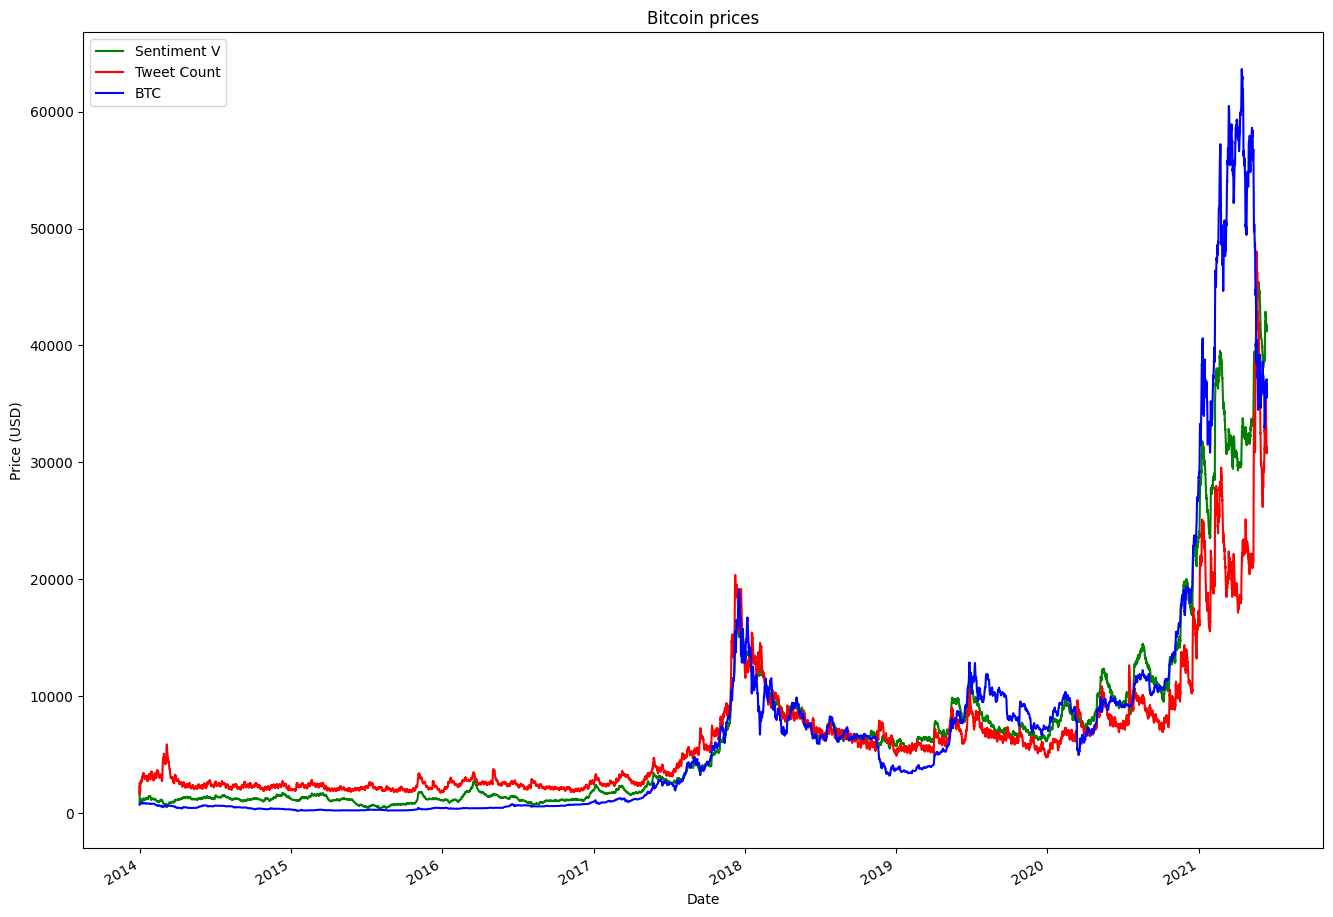

In [16]:
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100

merge['sentiment_vz'].ewm(span = 900).mean().plot(style = 'g', label = 'Sentiment V')
merge['Datetime_z'].ewm(span = 400).mean().plot(style = 'r', label = 'Tweet Count')
merge['Close_z'].ewm(span = 40).mean().plot(style = 'b', label = 'BTC')


plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

### Analisis de Correlación

Para ver la eficacia de la nueva métrica miraremos la correlación entre el precio y el sentimiento Global. Además, analizaremos si el cambio en el sentimiento afecta al precio o al reves.

Para ello creamos una función auxiliar que nos ayude con la busqueda


In [17]:
def get_max_corr(col1, col2, c_lambda = lambda x: x, index_range = (-100, 100)):
    ''' Encuentra el punto con mayor correlación y muestra una gráfica del rango.'''
    
    curr_range = range(index_range[0],index_range[1])
    coor_data = [col1.corr(c_lambda(col2, i)) for i in curr_range]

    print("-"*50)
    print(f"Index of the max corr {index_range[0]+coor_data.index(max(coor_data))}")
    print(f"Max corr {max(coor_data)}")
    print("-"*50)
    
    plt.rcParams['figure.figsize'] = [16, 5]
    plt.rcParams['figure.dpi'] = 100

    sns.lineplot(x = curr_range, y=coor_data)

### Correlación Precio - Sentimiento Global

### Correlación entre Precio - Sentimiento Global (Shift)

--------------------------------------------------
Index of the max corr 36
Max corr 0.8302085109594717
--------------------------------------------------


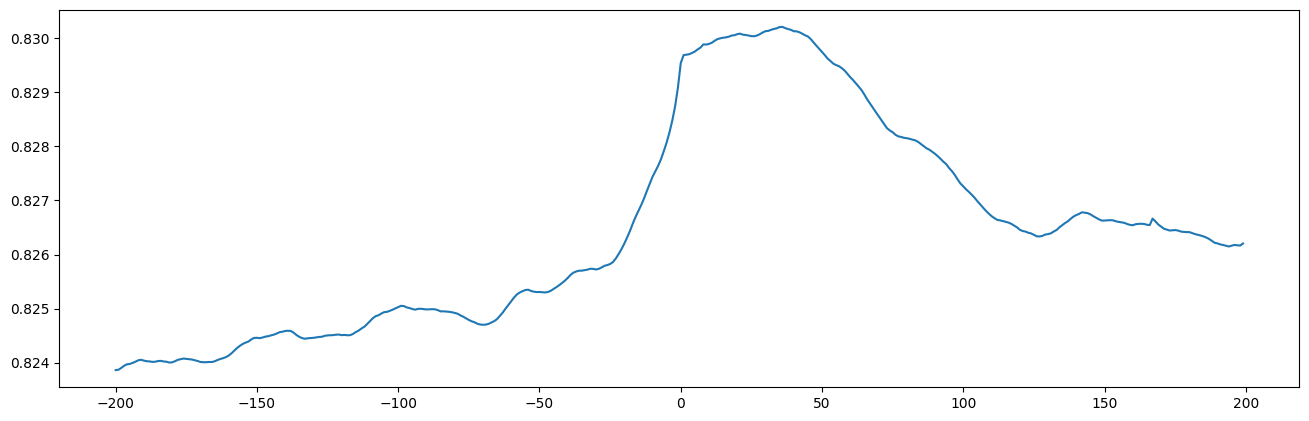

In [18]:
shift_l = lambda data , i: data.shift(periods = i)
get_max_corr(merge['Close'], merge['sentiment_vz'], shift_l, index_range=(-200,200))

### Correlación entre Precio - Sentimiento Global (EWM)

--------------------------------------------------
Index of the max corr 2626
Max corr 0.9586898643706594
--------------------------------------------------


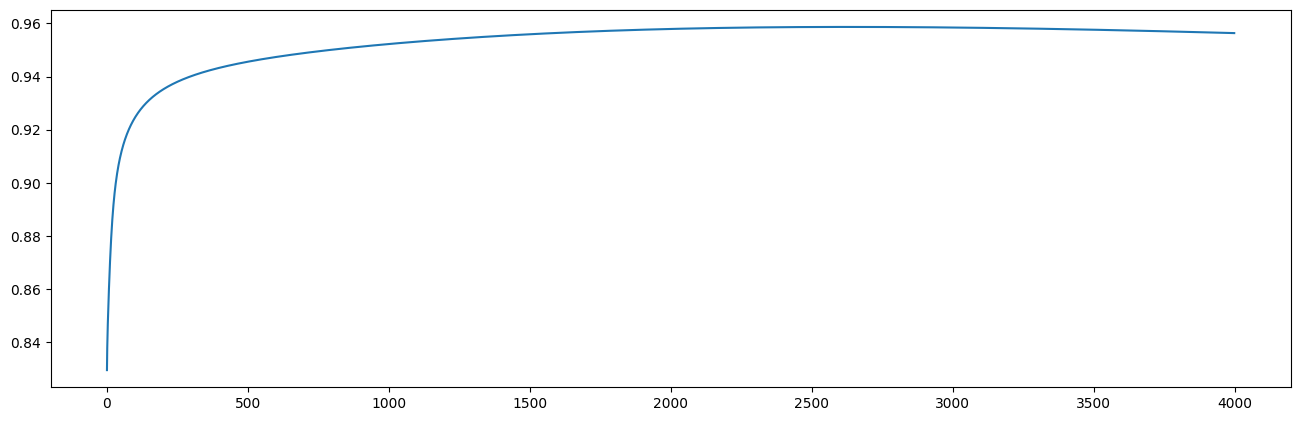

In [19]:
ewm_move = lambda data , i: data.ewm(span = i).mean()
get_max_corr(merge['Close'], merge['sentiment_vz'], ewm_move, index_range=(1,4000))

### Correlación entre Precio - Sentimiento Global (Shift + EWM)

--------------------------------------------------
Index of the max corr -58
Max corr 0.9496718889149781
--------------------------------------------------


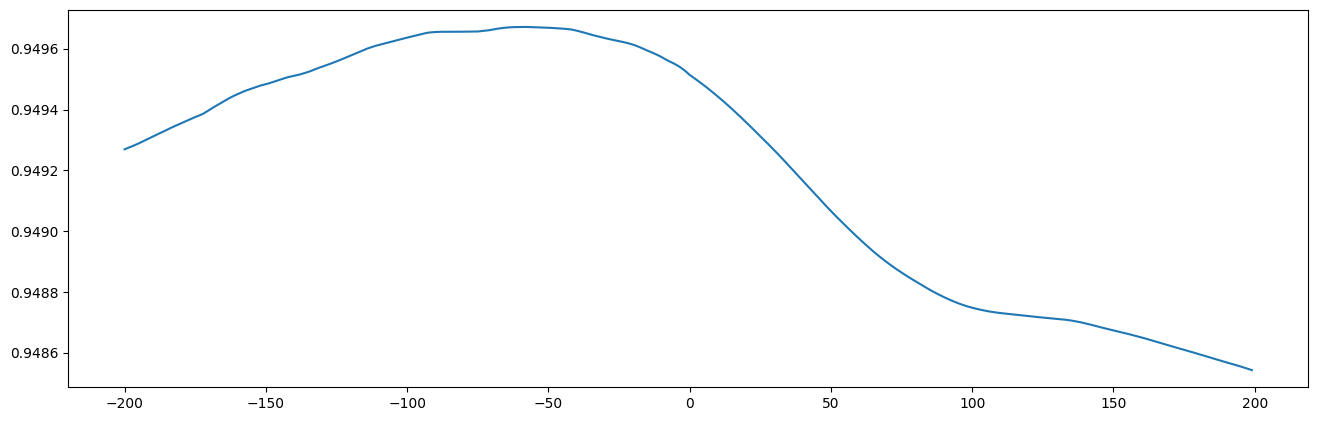

In [20]:
shift_ewm = lambda data , i: data.ewm(span = 750).mean().shift(periods = i)
get_max_corr(merge['Close'], merge['sentiment_vz'], shift_ewm, index_range=(-200,200))

## **Resultados**

In [21]:
corr_sent = merge['Close'].corr(merge['sentiment_v'])
corr_sent_emv = merge['Close'].corr(merge['sentiment_v'].ewm(span = 2600).mean())

corr_sent_log = np.log(merge['Close']).corr(np.log(merge['sentiment_v']))
corr_sent_emv_log = np.log(merge['Close']).corr(np.log(merge['sentiment_v'].ewm(span = 1200).mean()))

corr_n_t = merge['Close'].corr(merge['Datetime'])
corr_n_t_emv = merge['Close'].corr(merge['Datetime'].ewm(span = 2600).mean())

corr_n_t_log = np.log(merge['Close']).corr(np.log(merge['Datetime']))
corr_n_t_emv_log = np.log(merge['Close']).corr(np.log(merge['Datetime'].ewm(span = 1200).mean()))

print("La correlación entre el precio y sentimiento es de %.4f" % corr_sent )
print("La correlación entre el precio y sentimiento (emv) es de %.4f" % corr_sent_emv )
print("La correlación entre el log precio y log sentimiento es de %.4f" % corr_sent_log )
print("La correlación entre el log precio y log sentimiento (emv) es de %.4f" % corr_sent_emv_log )
print("\n")
print("La correlación entre el precio y n_tweets es de %.4f" % corr_n_t )
print("La correlación entre el precio y n_tweets (emv) es de %.4f" % corr_n_t_emv )
print("La correlación entre el log precio y log n_tweets es de %.4f" % corr_n_t_log )
print("La correlación entre el log precio y log n_tweets (emv) es de %.4f" % corr_n_t_emv_log )

La correlación entre el precio y sentimiento es de 0.8295
La correlación entre el precio y sentimiento (emv) es de 0.9587
La correlación entre el log precio y log sentimiento es de 0.8870
La correlación entre el log precio y log sentimiento (emv) es de 0.9719


La correlación entre el precio y n_tweets es de 0.7585
La correlación entre el precio y n_tweets (emv) es de 0.9204
La correlación entre el log precio y log n_tweets es de 0.8767
La correlación entre el log precio y log n_tweets (emv) es de 0.9570


C:\Users\whiwho\Anaconda3\envs\JABA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
